### Santolik_with_RBSP_5_2019
    This is the notebook I was using to develop santolik_methods.py. 
    I haven't gone through this to see if it still works!
    
    There might be some useful stuff in here, re: peak detection (for identifying a whistler), and some comparisons
    of the 6th channel synthesis. But the other two notebooks are probably more functional
    -- Austin, 4.13.2020
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import datetime
import scipy.signal
import scipy.linalg
import matplotlib.gridspec as gridspec
from scipy import interpolate
from scipy import ndimage


import bisect
# %matplotlib notebook
# %matplotlib notebook
D2R = np.pi/180.
R2D = 180./np.pi
Hz2Rad = 2.*np.pi
Rad2Hz = 1./Hz2Rad

# %matplotlib notebook


from scipy.fftpack import fft
from scipy.signal.windows import hann, blackman, nuttall


Q_EL = 1.602e-19
M_EL = 9.1e-31
eo   = 8.854e-12
B0   = 30e-6
VC    = 2.998e8
mu = 4.*np.pi*10e-7

# Reduce precision when printing stuff out...
np.set_printoptions(precision=3,suppress=False)

%load_ext autoreload
%autoreload 2


# --------------- Latex Plot Beautification --------------------------
fig_width = 10
fig_height = 7
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

from santolik_methods import *

dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])


/Users/austin/Dropbox/CU LAIR/CANVAS/Santolik Method Examples/santolik_methods.py:407: RuntimeWarning: invalid value encountered in true_divide
  ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/np.imag(FBz)


filling imag
1.7127561843462166e-13 5.751955184783521e-09
2.0183564285327627e-13 3.043034924373628e-09
3.464813855168913e-12 1.236639016869463e-08
2.34199664186918e-13 2.6278095336695384e-05
5.468414500895689e-17 2.6560613553754985e-12
4.167982334349447e-18 4.541398113274155e-12
3.247438848581774e-17 1.1169757220533766e-12


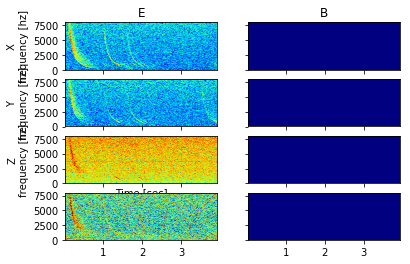

In [2]:
datadir = 'RBSP_example_data_data/'
d = os.listdir(datadir)
files = sorted([x for x in d if x.endswith('.sav')])

file_index = 0
file = files[file_index]

data = scipy.io.readsav(os.path.join(datadir,file))
print(data.keys())
tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
# print(data.keys())

# RBSP data is in mV/m, and nT. Cast to V/m and T
ex   = data['local_e12']*1e-3
ey   = data['local_e34']*1e-3
ez   = data['local_e56']*1e-3
bx   = data['local_scmx']*1e-9
by   = data['local_scmy']*1e-9
bz   = data['local_scmz']*1e-9


tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
# print(np.array(tvec))
# fs = 1.0/np.diff(data['local_et']).mean()
fs = 16000

fig = plot_spec(ex, ey, ez, bx, by, bz, fs, E_clims=[-11,-8], B_clims=[-11.6,-9.2])

# fig.savefig('peak_vs_avg/spectrogram_file_%d.png'%file_index)

In [3]:
def wrap(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))
    
def santolik_spectrogram(ff,tt,FEx, FEy, FEz, FBx, FBy, FBz):


    theta_grid = np.zeros([len(ff),len(tt)])
    phi_grid   = np.zeros([len(ff),len(tt)])
    nmag_grid  = np.zeros([len(ff),len(tt)])
    planarity  = np.zeros([len(ff),len(tt)])
    Qmag       = np.zeros([len(ff),len(tt)])



    # Do the loop per frequency and per time:
#     ti = 1
#     fi = 50

#     t = tt[ti]
#     # f = ff[fi]
    for ti in range(len(tt)):
        if(ti%10==0):
            print("doing t",ti)
        t = tt[ti]
        for fi in np.arange(1,len(ff)):
    #         print("freq:",fi)

            z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
            Q = np.outer(z,np.conj(z))

            A = []
            B = []
            for l in range(6):
                A_tmp = np.zeros([3,3],'complex')
                B_tmp = np.zeros([3],'complex')

                # Valid entries in Levi-Civita symbol (minus 1, because python is zero-indexed)
                for e,i,j,k in ([1,0,1,2],[1,1,2,0],[1,2,0,1],[-1,0,2,1],[-1,1,0,2],[-1,2,1,0]):
                    A_tmp[i,j] = e*Q[k+3,l]
                    B_tmp[i]= Q[i,l]
                A.extend(A_tmp)
                B.extend(B_tmp)
            # print(np.array(A))
            # print(np.array(B))
            A2 = np.concatenate([np.real(A),np.imag(A)],axis=0)
            B2 = np.concatenate([np.real(B),np.imag(B)],axis=0)

            U,s,VT=np.linalg.svd(A2,full_matrices=False)
            V = VT.T
            W_inv = np.linalg.inv(np.diag(s))
            n = np.linalg.multi_dot([V,W_inv,U.T,B2])

            # angles
            theta = np.arctan(np.sqrt(n[0]**2 + n[1]**2)/n[2])
            phi   = np.arctan(n[1]/n[0])
            if (n[0]<0 and n[2] < 0):
                phi -= np.pi
            if (n[0]<0 and n[2] >= 0):
                phi += np.pi

            theta_grid[fi,ti]= theta
            phi_grid[fi,ti]  = phi
            nmag_grid[fi,ti] = np.linalg.norm(n)

            # Planarity:
            beta = A2.dot(n)
            big_N = np.sum(pow(beta - B2,2))
            big_D = np.sum(pow(np.abs(beta) + np.abs(B2),2))
            planarity[fi,ti] = 1 - np.sqrt(big_N/big_D)
            
            Qmag[fi,ti] = np.sum(np.trace(Q))

    return ff, tt, theta_grid, phi_grid, nmag_grid, planarity



def santolik_Q(Q):
    try:
        A = []
        B = []
        for l in range(6):
            A_tmp = np.zeros([3,3],'complex')
            B_tmp = np.zeros([3],'complex')

            # Valid entries in Levi-Civita symbol (minus 1, because python is zero-indexed)
            for e,i,j,k in ([1,0,1,2],[1,1,2,0],[1,2,0,1],[-1,0,2,1],[-1,1,0,2],[-1,2,1,0]):
                A_tmp[i,j] = e*Q[k+3,l]
                B_tmp[i]= Q[i,l]
            A.extend(A_tmp)
            B.extend(B_tmp)

        A2 = np.concatenate([np.real(A),np.imag(A)],axis=0)
        B2 = np.concatenate([np.real(B),np.imag(B)],axis=0)

        U,s,VT=np.linalg.svd(A2,full_matrices=False)
        V = VT.T
        W_inv = np.linalg.inv(np.diag(s))
        n = np.linalg.multi_dot([V,W_inv,U.T,B2])

        # angles
        theta = np.arctan(np.sqrt(n[0]**2 + n[1]**2)/n[2])
        phi   = np.arctan(n[1]/n[0])
        
        theta = wrap(theta)
        phi = wrap(phi) 
#         print(theta,phi)
#         if (n[0]<0 and n[2] < 0):
#             phi -= np.pi
#         if (n[0]<0 and n[2] >= 0):
#             phi += np.pi

        nmag = np.linalg.norm(n)

        # Planarity:
        beta = A2.dot(n)
        big_N = np.sum(pow(beta - B2,2))
        big_D = np.sum(pow(np.abs(beta) + np.abs(B2),2))
        planarity = 1 - np.sqrt(big_N/big_D)

        return theta, phi, planarity
    except:
        return 0, 0, 0
    
def fill_nans(x,y,array):
#     print(np.shape(x), np.shape(y), np.shape(array))
    interp=interpolate.interp2d(x,y[1:-1],array[1:-1,:],kind='cubic',fill_value=None)
    newvals = interp(x,y[0])
    array[0,:] = newvals
    newvals = interp(x,y[-1])
    array[-1,:] = newvals




dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


Getting Q matrices


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


f_blurred is (129, 494)
(129,)


NameError: name 'flux_avg' is not defined

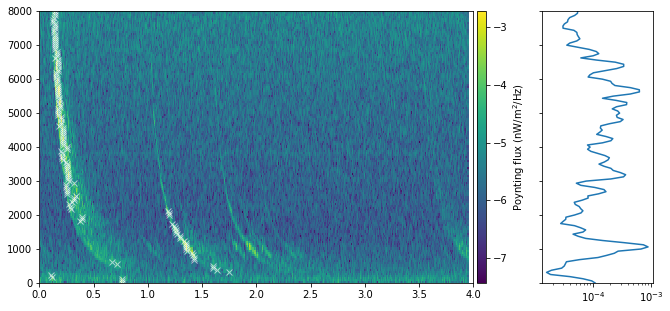

In [5]:
# file_index = 18
for file_index in range(len(files)):
# for file_index in [18]:
    file = files[file_index]

    data = scipy.io.readsav(os.path.join(datadir,file))
    print(data.keys())
    tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
    # print(data.keys())
    ex   = data['local_e12']*1e-3
    ey   = data['local_e34']*1e-3
    ez   = data['local_e56']*1e-3
    bx   = data['local_scmx']*1e-9
    by   = data['local_scmy']*1e-9
    bz   = data['local_scmz']*1e-9


    tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
    # print(np.array(tvec))
    # fs = 1.0/np.diff(data['local_et']).mean()
    fs = 16000

    # fig = plot_spec(ex, ey, ez, bx, by, bz, fs, E_clims=[-8,-5], B_clims=[-5.6,-2.2])

    # fig.savefig('peak_vs_avg/spectrogram_file_%d.png'%file_index)

    overlap = 0.5
    nfft = 256
    window = nuttall(nfft)

    ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

    ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

        # Recreate Ez, because it's noisy and it sucks
    ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/np.real(FBz)
    ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/np.imag(FBz)


    if np.sum(np.isnan(ReEz))>0:
        print('filling real')
        fill_nans(tt,ff,ReEz)
    if np.sum(np.isnan(ImEz))>0:
        print('filling imag')
        fill_nans(tt,ff,ImEz)

    newEz = ReEz + 1j*ImEz

    # Get poynting flux
    flux = np.zeros([len(ff), len(tt)])

    FB = np.array([FBx, FBy, FBz])
    FE = np.array([FEx, FEy, FEz])
    for ti in range(len(tt)):
        for fi in range(len(ff)):  
            poy = np.cross(FE[:,fi,ti], FB[:,fi,ti])
            flux[fi,ti] = np.real(np.linalg.norm(poy))
    flux = np.real(flux)/mu


    # Generate Q matrix, so we can play with it
    print("Getting Q matrices")
    Qvec = np.zeros([len(tt), len(ff),6,6])
    for ti in range(len(tt)):
        t = tt[ti]
        for fi in np.arange(1,len(ff)):
            z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
            Q = np.outer(z,np.conj(z))

            Qvec[ti,fi] = Q


    thresh_multiplier = 3
    # Get threshold magnitude:
    # (Sum of the auto power spectra)
    F_mags = np.absolute(VC*(FBx*np.conj(FBx) + FBy*np.conj(FBy) + FBz*np.conj(FBz)) 
                          + (FEx*np.conj(FEx) + FEy*np.conj(FEy) + FEz*np.conj(FEz)))

    # Get average
    F_blurred = ndimage.uniform_filter(flux, size=3)
    print('f_blurred is', np.shape(F_blurred))
    F_avg  = np.sum(F_blurred,axis=-1)/(np.shape(F_mags)[0])
    thresh = np.where(F_blurred - F_avg[:,np.newaxis]*thresh_multiplier > 0)
    # sparse = FD_full_to_sparse([FEx, FEy, FBx, FBy, FBz], thresh)

    Fxs = np.zeros_like(FEx, 'complex')
    Fxs[thresh] = FEx[thresh]

    # fig, ax = plt.subplots(1,1)
    # ax.pcolormesh(tt,ff,np.log10(np.abs(Fxs)))
    print(np.shape(F_avg))
    theta_vec = np.zeros([len(ff), len(tt)])
    phi_vec   = np.zeros([len(ff), len(tt)])
    plan_vec  = np.zeros([len(ff), len(tt)])

    for fi,ti in zip(thresh[0], thresh[1]):
        theta, phi, planarity = santolik_Q(Qvec[ti,fi,:,:])
        theta_vec[fi,ti] = theta
        phi_vec[fi,ti] = phi
        plan_vec[fi,ti] = planarity


    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)

    theta_pk = np.zeros(len(ff))
    phi_pk   = np.zeros(len(ff))
    plan_pk  = np.zeros(len(ff))

    for fi in range(len(ff)):
        theta_pk[fi], phi_pk[fi], plan_pk[fi] = santolik_Q(Qvec[tmax_inds[fi], fi, :, :])

#     flux_pk = np.array([flux[fi, tmax_inds[fi]] for fi in range(len(ff))])
    # use the blurred flux, because it's smoother and prettier
    flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])

    # Previous cell break here    

    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # --------------- Latex Plot Beautification --------------------------
    fig_width = 10
    fig_height = 4
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------

    fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
    im1 = ax[0].pcolormesh(tt,ff,np.log10(flux*1e9))
    # ax[1].plot(tt[tmax_inds], ff)

    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cb = fig.colorbar(im1, cax=cax, orientation='vertical')
    cb.set_label('Poynting flux (nW/m$^2$/Hz)')
    ax[0].plot(tt[tmax_inds], ff, 'wx',alpha=0.6)
    ax[0].set_xlim([0,4])
    ax[0].set_ylim([0, 8000])

    ax[1].semilogx(flux_pk*1e9,  ff, label = 'Peak')
    ax[1].semilogx(flux_avg*1e9, ff, label = 'Avg')
    ax[1].legend()
    ax[0].set_ylabel('Frequency (Hz)')
    ax[0].set_xlabel('Time (sec)')
    ax[1].set_xlabel('Poynting Flux\n(nW/m$^2$/Hz)')

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('File %d\n%s'%(file_index, file));
    fig.savefig('peak_vs_avg/peak_locations_file_%d.png'%file_index)



    # Compare the Santolik computed parameters on the peak location, vs the (Q) average across the whole spectrogram:
    Q_avg = np.sum(Qvec, axis=0)/len(tt)

    theta_avg = np.zeros(len(ff))
    phi_avg   = np.zeros(len(ff))
    plan_avg  = np.zeros(len(ff))
    flux_avg  = np.mean(flux,axis=-1)
    for i in range(len(ff)):
        theta_avg[i], phi_avg[i], plan_avg[i] = santolik_Q(Q_avg[i])


    # --------------- Latex Plot Beautification --------------------------
    fig_width = 10
    fig_height = 6
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------    

    fig, ax = plt.subplots(4,1, sharex = True)
    ax[0].plot(ff, (theta_avg*R2D));
    ax[0].plot(ff, (theta_pk*R2D));
    ax[1].plot(ff, (phi_avg*R2D));
    ax[1].plot(ff, (phi_pk*R2D));
    ax[2].plot(ff, plan_avg, label='4 sec avg')
    ax[2].plot(ff, plan_pk, label ='Peak')
    ax[3].semilogy(ff, flux_pk*1e9, label = 'Peak')
    ax[3].semilogy(ff, flux_avg*1e9, label = 'Avg')
    ax[3].legend()
    ax[0].set_ylabel(r'$\theta$')
    ax[1].set_ylabel(r'$\phi$')
    ax[2].set_ylabel('planarity')
    ax[3].set_xlabel('Frequency(Hz)')
    ax[3].set_ylabel('Poynting flux\nnW/m$^2$/Hz')
    ax[0].set_ylim([-100,100])
    ax[1].set_ylim([-190,190])
    ax[2].set_ylim([0,1])
    ax[3].set_xlim([0,8000])
    fig.suptitle('File %d\n%s'%(file_index, file));
    fig.savefig('peak_vs_avg/peak_vs_avg_comparison_file_%d.png'%file_index)
    # ax.plot(ff, phi_avg*R2D)
    # ax.plot(ff, plan_avg)
    plt.close('all')


(129, 494)
(494, 129, 6, 6)
(129,)


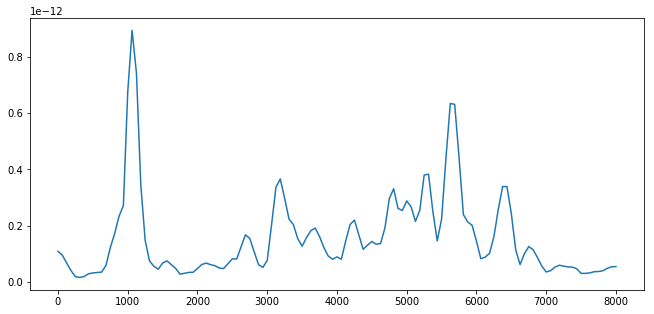

In [6]:
print(np.shape(flux))
print(np.shape(Qvec))
flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])
print(np.shape(flux_pk))
fig,ax = plt.subplots(1,1)
ax.plot(ff,flux_pk);
# fig, ax = plt.subplots(2,1)
# ax[0].pcolormesh(tt,ff,np.log10(F_mags))
# ax[1].pcolormesh(tt,ff,np.log10(flux))



In [7]:
file = files[18]

data = scipy.io.readsav(os.path.join(datadir,file))
print(data.keys())
tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
# print(data.keys())
ex   = data['local_e12']
ey   = data['local_e34']
ez   = data['local_e56']
bx   = data['local_scmx']
by   = data['local_scmy']
bz   = data['local_scmz']


tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
# print(np.array(tvec))
# fs = 1.0/np.diff(data['local_et']).mean()
fs = 16000
ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

flux = np.zeros_like(FBx)

FB = np.array([FBx, FBy, FBz])
FE = np.array([FEx, FEy, FEz])
for ti in range(len(tt)):
    for fi in range(len(ff)):  
        poy = np.cross(FE[:,fi,ti], FB[:,fi,ti])
        flux[fi,ti] = np.real(np.linalg.norm(poy))
flux = np.real(flux)

dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])


## This version to split up a single file into subsections in time!


dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


Getting Q matrices


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


f_blurred is (129, 495)
(129,)


NameError: name 'flux_avg' is not defined

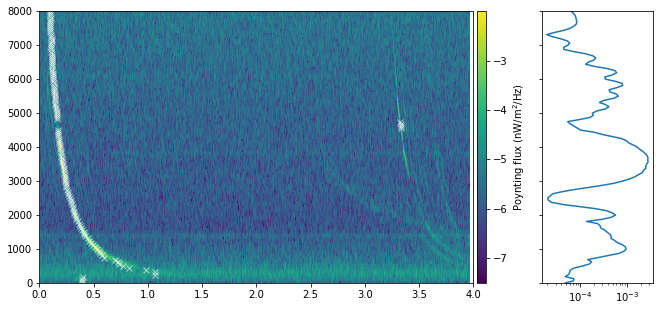

In [8]:
file_index = 18
# for file_index in range(len(files)):

file = files[file_index]

data = scipy.io.readsav(os.path.join(datadir,file))
print(data.keys())
tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
# print(data.keys())
ex   = data['local_e12']*1e-3
ey   = data['local_e34']*1e-3
ez   = data['local_e56']*1e-3
bx   = data['local_scmx']*1e-9
by   = data['local_scmy']*1e-9
bz   = data['local_scmz']*1e-9


tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
# print(np.array(tvec))
# fs = 1.0/np.diff(data['local_et']).mean()
fs = 16000

# fig = plot_spec(ex, ey, ez, bx, by, bz, fs, E_clims=[-8,-5], B_clims=[-5.6,-2.2])

# fig.savefig('peak_vs_avg/spectrogram_file_%d.png'%file_index)

overlap = 0.5
nfft = 256
window = nuttall(nfft)

ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

    # Recreate Ez, because it's noisy and it sucks
ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/np.real(FBz)
ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/np.imag(FBz)


if np.sum(np.isnan(ReEz))>0:
    print('filling real')
    fill_nans(tt,ff,ReEz)
if np.sum(np.isnan(ImEz))>0:
    print('filling imag')
    fill_nans(tt,ff,ImEz)

newEz = ReEz + 1j*ImEz

# Get poynting flux
flux = np.zeros([len(ff), len(tt)])

FB = np.array([FBx, FBy, FBz])
FE = np.array([FEx, FEy, FEz])
for ti in range(len(tt)):
    for fi in range(len(ff)):  
        poy = np.cross(FE[:,fi,ti], FB[:,fi,ti])
        flux[fi,ti] = np.real(np.linalg.norm(poy))
flux = np.real(flux)/mu


# Generate Q matrix, so we can play with it
print("Getting Q matrices")
Qvec = np.zeros([len(tt), len(ff),6,6])
for ti in range(len(tt)):
    t = tt[ti]
    for fi in np.arange(1,len(ff)):
        z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
        Q = np.outer(z,np.conj(z))

        Qvec[ti,fi] = Q


thresh_multiplier = 3
# Get threshold magnitude:
# (Sum of the auto power spectra)
# F_mags = np.absolute(VC*(FBx*np.conj(FBx) + FBy*np.conj(FBy) + FBz*np.conj(FBz)) 
#                       + (FEx*np.conj(FEx) + FEy*np.conj(FEy) + FEz*np.conj(FEz)))

# Get average
F_blurred = ndimage.uniform_filter(flux, size=3)
print('f_blurred is', np.shape(F_blurred))
F_avg  = np.sum(F_blurred,axis=-1)/(np.shape(F_mags)[0])
thresh = np.where(F_blurred - F_avg[:,np.newaxis]*thresh_multiplier > 0)
# sparse = FD_full_to_sparse([FEx, FEy, FBx, FBy, FBz], thresh)

Fxs = np.zeros_like(FEx, 'complex')
Fxs[thresh] = FEx[thresh]

# fig, ax = plt.subplots(1,1)
# ax.pcolormesh(tt,ff,np.log10(np.abs(Fxs)))
print(np.shape(F_avg))
theta_vec = np.zeros([len(ff), len(tt)])
phi_vec   = np.zeros([len(ff), len(tt)])
plan_vec  = np.zeros([len(ff), len(tt)])

for fi,ti in zip(thresh[0], thresh[1]):
    theta, phi, planarity = santolik_Q(Qvec[ti,fi,:,:])
    theta_vec[fi,ti] = theta
    phi_vec[fi,ti] = phi
    plan_vec[fi,ti] = planarity


# Find peak index for each frequency:
tmax_inds = np.argmax(F_blurred, axis=1)

theta_pk = np.zeros(len(ff))
phi_pk   = np.zeros(len(ff))
plan_pk  = np.zeros(len(ff))

for fi in range(len(ff)):
    theta_pk[fi], phi_pk[fi], plan_pk[fi] = santolik_Q(Qvec[tmax_inds[fi], fi, :, :])

#     flux_pk = np.array([flux[fi, tmax_inds[fi]] for fi in range(len(ff))])
# use the blurred flux, because it's smoother and prettier
flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])

# Previous cell break here    

# Find peak index for each frequency:
tmax_inds = np.argmax(F_blurred, axis=1)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# --------------- Latex Plot Beautification --------------------------
fig_width = 10
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im1 = ax[0].pcolormesh(tt,ff,np.log10(flux*1e9))
# ax[1].plot(tt[tmax_inds], ff)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label('Poynting flux (nW/m$^2$/Hz)')
ax[0].plot(tt[tmax_inds], ff, 'wx',alpha=0.6)
ax[0].set_xlim([0,4])
ax[0].set_ylim([0, 8000])

ax[1].semilogx(flux_pk*1e9,  ff, label = 'Peak')
ax[1].semilogx(flux_avg*1e9, ff, label = 'Avg')
ax[1].legend()
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (sec)')
ax[1].set_xlabel('Poynting Flux\n(nW/m$^2$/Hz)')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('File %d\n%s'%(file_index, file));
# fig.savefig('peak_vs_avg/peak_locations_file_%d.png'%file_index)

(495, 129, 6, 6)


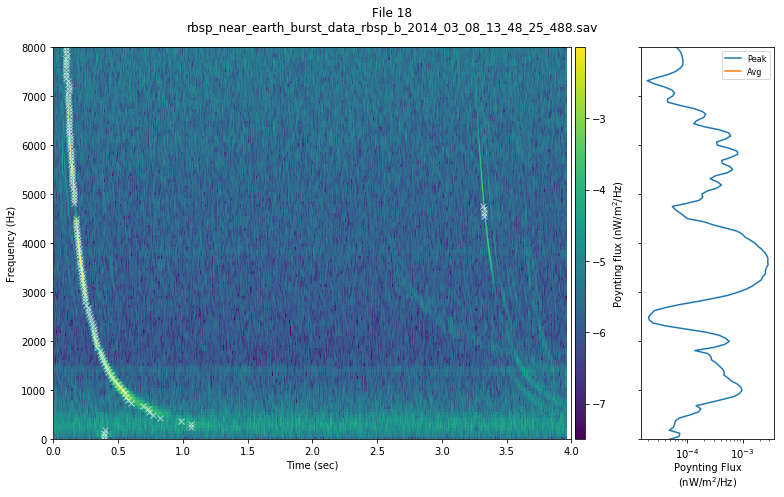

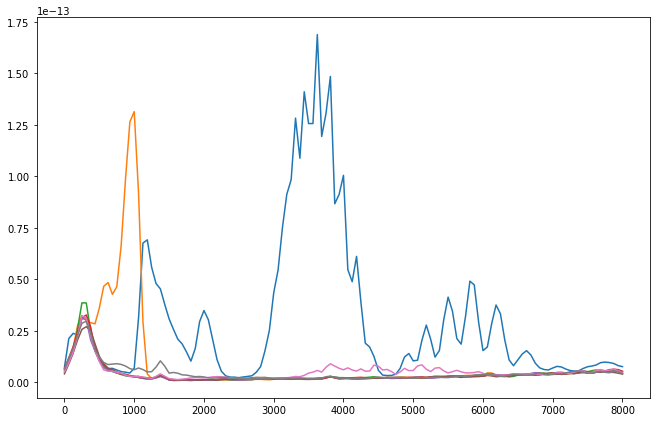

In [198]:
# Compare the Santolik computed parameters on the peak location, vs the (Q) average across the whole spectrogram:
fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im1 = ax[0].pcolormesh(tt,ff,np.log10(flux*1e9))
# ax[1].plot(tt[tmax_inds], ff)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label('Poynting flux (nW/m$^2$/Hz)')
ax[0].plot(tt[tmax_inds], ff, 'wx',alpha=0.6)
ax[0].set_xlim([0,4])
ax[0].set_ylim([0, 8000])

ax[1].semilogx(flux_pk*1e9,  ff, label = 'Peak')
ax[1].semilogx(flux_avg*1e9, ff, label = 'Avg')
ax[1].legend()
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (sec)')
ax[1].set_xlabel('Poynting Flux\n(nW/m$^2$/Hz)')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('File %d\n%s'%(file_index, file));



subsample_length = 0.5 # seconds

t_sub = np.arange(0,np.ceil(tt[-1]+subsample_length),subsample_length)


t_pairs = list(zip(t_sub[0:-1], t_sub[1:]))
# print(t_pairs)

fig, ax = plt.subplots(1,1)
print(np.shape(Qvec))
for t1, t2 in t_pairs:
#     inds = np.where((tt >= t1) & (tt < t2))
#     print(inds)
    Q_avg = np.sum(Qvec[(tt >= t1) & (tt < t2),:,:,:], axis=0)/len(tt)
    theta_avg = np.zeros(len(ff))
    phi_avg   = np.zeros(len(ff))
    plan_avg  = np.zeros(len(ff))
    flux_avg  = np.mean(flux[:,(tt >= t1) & (tt < t2)],axis=-1)


    for i in range(len(ff)):
        theta_avg[i], phi_avg[i], plan_avg[i] = santolik_Q(Q_avg[i])

    ax.plot(ff, flux_avg)
    
    

dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Getting Q matrices


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part


f_blurred is (129, 495)
(129,)
[0. 2. 4.]
(495, 129, 6, 6)


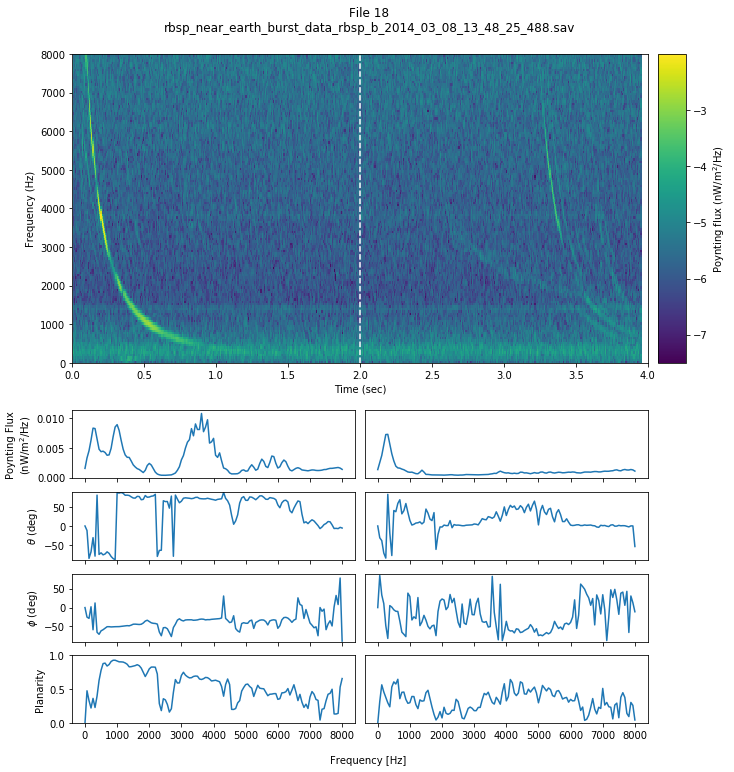

In [138]:
# Everything on one cool divided plot! Fuck, this is dope

subsample_length = 2 # seconds

file_index = 16
# for file_index in range(len(files)):
for file_index in [18]:
    file = files[file_index]

    data = scipy.io.readsav(os.path.join(datadir,file))
    print(data.keys())
    tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
    # print(data.keys())
    ex   = data['local_e12']*1e-3
    ey   = data['local_e34']*1e-3
    ez   = data['local_e56']*1e-3
    bx   = data['local_scmx']*1e-9
    by   = data['local_scmy']*1e-9
    bz   = data['local_scmz']*1e-9


    tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
    # print(np.array(tvec))
    # fs = 1.0/np.diff(data['local_et']).mean()
    fs = 16000

    # fig = plot_spec(ex, ey, ez, bx, by, bz, fs, E_clims=[-8,-5], B_clims=[-5.6,-2.2])

    # fig.savefig('peak_vs_avg/spectrogram_file_%d.png'%file_index)

    overlap = 0.5
    nfft = 256
    window = nuttall(nfft)

    ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

    ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
    ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

        # Recreate Ez, because it's noisy and it sucks
    ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/np.real(FBz)
    ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/np.imag(FBz)


    if np.sum(np.isnan(ReEz))>0:
        print('filling real')
        fill_nans(tt,ff,ReEz)
    if np.sum(np.isnan(ImEz))>0:
        print('filling imag')
        fill_nans(tt,ff,ImEz)

    newEz = ReEz + 1j*ImEz

    # Get poynting flux
    flux = np.zeros([len(ff), len(tt)])

    FB = np.array([FBx, FBy, FBz])
    FE = np.array([FEx, FEy, FEz])
    for ti in range(len(tt)):
        for fi in range(len(ff)):  
            poy = np.cross(FE[:,fi,ti], FB[:,fi,ti])
            flux[fi,ti] = np.real(np.linalg.norm(poy))
    flux = np.real(flux)/mu


    # Generate Q matrix, so we can play with it
    print("Getting Q matrices")
    Qvec = np.zeros([len(tt), len(ff),6,6])
    for ti in range(len(tt)):
        t = tt[ti]
        for fi in np.arange(1,len(ff)):
            z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
            Q = np.outer(z,np.conj(z))

            Qvec[ti,fi] = Q


    thresh_multiplier = 3
    # Get threshold magnitude:
    # (Sum of the auto power spectra)
    # F_mags = np.absolute(VC*(FBx*np.conj(FBx) + FBy*np.conj(FBy) + FBz*np.conj(FBz)) 
    #                       + (FEx*np.conj(FEx) + FEy*np.conj(FEy) + FEz*np.conj(FEz)))

    # Get average
    F_blurred = ndimage.uniform_filter(flux, size=3)
    print('f_blurred is', np.shape(F_blurred))
    F_avg  = np.sum(F_blurred,axis=-1)/(np.shape(F_blurred)[0])
    thresh = np.where(F_blurred - F_avg[:,np.newaxis]*thresh_multiplier > 0)
    # sparse = FD_full_to_sparse([FEx, FEy, FBx, FBy, FBz], thresh)

    Fxs = np.zeros_like(FEx, 'complex')
    Fxs[thresh] = FEx[thresh]

    # fig, ax = plt.subplots(1,1)
    # ax.pcolormesh(tt,ff,np.log10(np.abs(Fxs)))
    print(np.shape(F_avg))
    theta_vec = np.zeros([len(ff), len(tt)])
    phi_vec   = np.zeros([len(ff), len(tt)])
    plan_vec  = np.zeros([len(ff), len(tt)])

    for fi,ti in zip(thresh[0], thresh[1]):
        theta, phi, planarity = santolik_Q(Qvec[ti,fi,:,:])
        theta_vec[fi,ti] = theta
        phi_vec[fi,ti] = phi
        plan_vec[fi,ti] = planarity


    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)

    theta_pk = np.zeros(len(ff))
    phi_pk   = np.zeros(len(ff))
    plan_pk  = np.zeros(len(ff))

    for fi in range(len(ff)):
        theta_pk[fi], phi_pk[fi], plan_pk[fi] = santolik_Q(Qvec[tmax_inds[fi], fi, :, :])

    #     flux_pk = np.array([flux[fi, tmax_inds[fi]] for fi in range(len(ff))])
    # use the blurred flux, because it's smoother and prettier
    flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])

    # Previous cell break here    

    # Find peak index for each frequency:
    tmax_inds = np.argmax(F_blurred, axis=1)


    # --------------- Latex Plot Beautification --------------------------
    fig_width = 10
    fig_height = 10
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 10,
              'font.size': 10,
              'legend.fontsize': 8,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    import matplotlib.gridspec as gridspec



    t_sub = np.arange(0,tt[-1] + subsample_length,subsample_length)
    print(t_sub)

    t_pairs = list(zip(t_sub[0:-1], t_sub[1:]))


    fig = plt.figure();

    widths = np.ones(len(t_pairs) + 1)
    widths[-1] = 0.1
    gs1 = gridspec.GridSpec(1, len(t_pairs) +1, width_ratios = widths)
    ax1 = plt.subplot(gs1[0, 0:-1])
    cax = plt.subplot(gs1[0, -1])

    im1 = ax1.pcolormesh(tt,ff,np.log10(flux*1e9))
    cb = fig.colorbar(im1, cax=cax, orientation='vertical')
    cb.set_label('Poynting flux (nW/m$^2$/Hz)')
    ax1.set_xlim([0,4])
    ax1.set_ylim([0, 8000])

    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_xlabel('Time (sec)')

    for t in t_sub:
        ax1.plot([t,t],[0,8000],'w--')
    print(np.shape(Qvec))

    flux_list = []
    theta_list =[]
    phi_list = []
    plan_list = []

    gs2 = gridspec.GridSpec(4, len(t_pairs) +1, width_ratios = widths)
    gs1.update(top=0.92, bottom=0.53, wspace=0.05)
    gs2.update(top=0.47, bottom=0.075, wspace=0.05)


    for ind, (t1, t2) in enumerate(t_pairs):
        ax = plt.subplot(gs2[0, ind])
        flux_list.append(ax)

        ax = plt.subplot(gs2[1, ind])
        theta_list.append(ax)

        ax = plt.subplot(gs2[2, ind])
        phi_list.append(ax)

        ax = plt.subplot(gs2[3, ind])
        plan_list.append(ax)


    for ind, (t1, t2) in enumerate(t_pairs):
        Q_avg = np.sum(Qvec[(tt >= t1) & (tt < t2),:,:,:], axis=0)/len(tt)
        theta_avg = np.zeros(len(ff))
        phi_avg   = np.zeros(len(ff))
        plan_avg  = np.zeros(len(ff))
        flux_sum  = np.sum(flux[:,(tt >= t1) & (tt < t2)],axis=-1)


        for i in range(len(ff)):
            theta_avg[i], phi_avg[i], plan_avg[i] = santolik_Q(Q_avg[i])

        # Plot poynting flux
        ax = flux_list[ind]
        ax.plot(ff, flux_sum*1e9)

        # Plot theta
        ax = theta_list[ind]
        ax.plot(ff, theta_avg*R2D)
        ax.set_ylim([-90,90])

        # Plot phi
        ax = phi_list[ind]
        ax.plot(ff, phi_avg*R2D)
        ax.set_ylim([-90,90])
    #     print(np.min(phi_avg*R2D), np.max(phi_avg*R2D))
        # Plot planarity
        ax = plan_list[ind]
        ax.plot(ff, plan_avg)
        ax.set_ylim([0,1])
    for ax in flux_list[1:]:
        ax.set_ylim(flux_list[0].get_ylim())
        ax.set_yticks([])
    for ax in theta_list[1:]:
        ax.set_yticks([])
    for ax in phi_list[1:]:
        ax.set_yticks([])
    for ax in plan_list[1:]:
        ax.set_yticks([])
    for ax in flux_list:
        ax.set_xticklabels([])
    for ax in theta_list:
        ax.set_xticklabels([])
    for ax in phi_list:
        ax.set_xticklabels([])

    fig.text(0.45, 0.025, "Frequency [Hz]")

    flux_list[0].set_ylabel('Poynting Flux\n(nW/m$^2$/Hz)');
    theta_list[0].set_ylabel(r'$\theta$ (deg)');
    phi_list[0].set_ylabel(r'$\phi$ (deg)');
    plan_list[0].set_ylabel('Planarity')

    fig.suptitle('File %d\n%s'%(file_index, file));

#     fig.savefig('subsampled_figures/subsampled_file_%d_%g_sec_resolution.png'%(file_index, subsample_length))

#     plt.close('all')

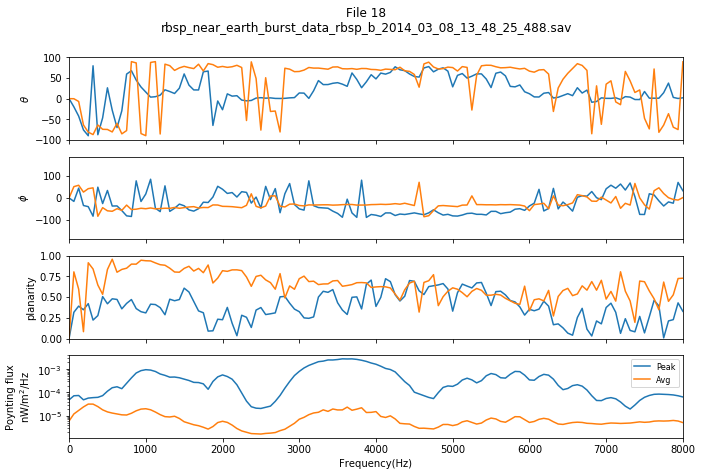

In [77]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 10
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------    

fig, ax = plt.subplots(4,1, sharex = True)
ax[0].plot(ff, (theta_avg*R2D));
ax[0].plot(ff, (theta_pk*R2D));
ax[1].plot(ff, (phi_avg*R2D));
ax[1].plot(ff, (phi_pk*R2D));
ax[2].plot(ff, plan_avg, label='4 sec avg')
ax[2].plot(ff, plan_pk, label ='Peak')
ax[3].semilogy(ff, flux_pk*1e9, label = 'Peak')
ax[3].semilogy(ff, flux_avg*1e9, label = 'Avg')
ax[3].legend()
ax[0].set_ylabel(r'$\theta$')
ax[1].set_ylabel(r'$\phi$')
ax[2].set_ylabel('planarity')
ax[3].set_xlabel('Frequency(Hz)')
ax[3].set_ylabel('Poynting flux\nnW/m$^2$/Hz')
ax[0].set_ylim([-100,100])
ax[1].set_ylim([-190,190])
ax[2].set_ylim([0,1])
ax[3].set_xlim([0,8000])
fig.suptitle('File %d\n%s'%(file_index, file));
# fig.savefig('peak_vs_avg/peak_vs_avg_comparison_file_%d.png'%file_index)
# ax.plot(ff, phi_avg*R2D)
# ax.plot(ff, plan_avg)
# plt.close('all')

dict_keys(['local_e12', 'local_e34', 'local_e56', 'local_et', 'local_scmx', 'local_scmy', 'local_scmz', 'local_scmt'])
filling imag


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: ComplexWarning: Casting complex values to real discards the imaginary part


Getting Q matrices
f_blurred is (129, 495)
(129,)


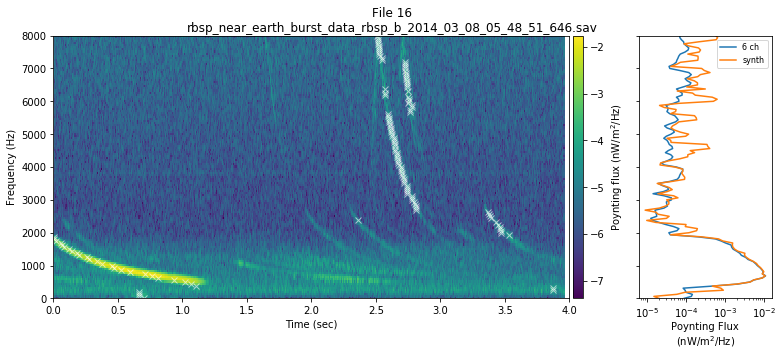

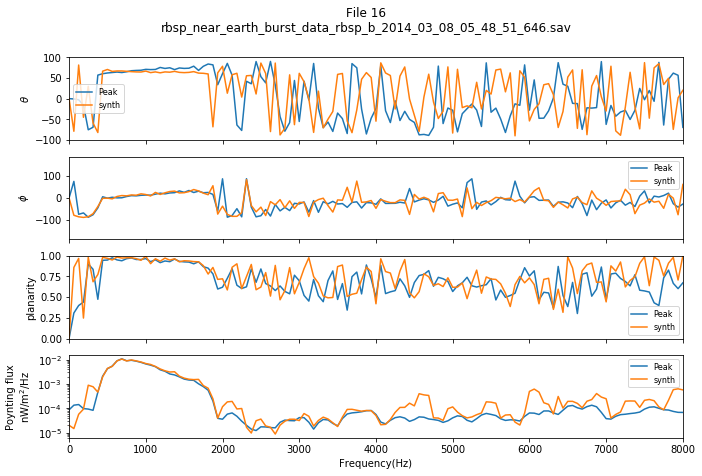

In [152]:
file_index = 16
# for file_index in range(len(files)):
# for file_index in [18]:
file = files[file_index]

data = scipy.io.readsav(os.path.join(datadir,file))
print(data.keys())
tvec = np.array([datetime.datetime.fromtimestamp(x) for x in data['local_et']])
# print(data.keys())
ex   = data['local_e12']*1e-3
ey   = data['local_e34']*1e-3
ez   = data['local_e56']*1e-3
bx   = data['local_scmx']*1e-9
by   = data['local_scmy']*1e-9
bz   = data['local_scmz']*1e-9


tvec = [datetime.datetime.fromtimestamp(x) for x in data['local_et']]
# print(np.array(tvec))
# fs = 1.0/np.diff(data['local_et']).mean()
fs = 16000

# fig = plot_spec(ex, ey, ez, bx, by, bz, fs, E_clims=[-8,-5], B_clims=[-5.6,-2.2])

# fig.savefig('peak_vs_avg/spectrogram_file_%d.png'%file_index)

overlap = 0.5
nfft = 256
window = nuttall(nfft)

ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

# Recreate Ez, because it's noisy and it sucks
dither = 1e-10
# ran = dither*(np.random.rand(np.shape(FEx)[0], np.shape(FEx)[1]) - 0.5)
ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/(np.real(FBz))# + dither)
# ran = dither #*(np.random.rand(np.shape(FEx)[0], np.shape(FEx)[1]) - 0.5)
ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/(np.imag(FBz))# + dither)


if np.sum(np.isnan(ReEz))>0:
    print('filling real')
    fill_nans(tt,ff,ReEz)
if np.sum(np.isnan(ImEz))>0:
    print('filling imag')
    fill_nans(tt,ff,ImEz)

newEz = ReEz + 1j*ImEz

# newEz +=    dither*(np.random.rand(np.shape(newEz)[0], np.shape(newEz)[1]) - 0.5)
# newEz += 1j*dither*(np.random.rand(np.shape(newEz)[0], np.shape(newEz)[1]) - 0.5)
# newEz = ndimage.uniform_filter(ReEz, size=1) + 1j*ndimage.uniform_filter(ImEz, size=1)


# Get poynting flux
FB = np.array([FBx, FBy, FBz])
FE = np.array([FEx, FEy, FEz])
flux = np.linalg.norm(np.cross(FE, FB, axis=0), axis=0)/mu

# Get poynting flux
FB = np.array([FBx, FBy, FBz])
FE = np.array([FEx, FEy, newEz])
flux_s = np.linalg.norm(np.cross(FE, FB, axis=0), axis=0)/mu




# Generate Q matrix, so we can play with it
print("Getting Q matrices")
Qvec = np.zeros([len(tt), len(ff),6,6])
Qvec_synth_Ez = np.zeros([len(tt), len(ff),6,6])

for ti in range(len(tt)):
    t = tt[ti]
    for fi in np.arange(1,len(ff)):
        z = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], FEz[fi,ti]],'complex')
        Q = np.outer(z,np.conj(z))

        Qvec[ti,fi] = Q

        z2 = np.array([VC*FBx[fi,ti], VC*FBy[fi,ti], VC*FBz[fi,ti], FEx[fi,ti], FEy[fi,ti], newEz[fi,ti]],'complex')
        Q2 = np.outer(z2,np.conj(z2))

        Qvec_synth_Ez[ti,fi] = Q2


thresh_multiplier = 3

# Get average
F_blurred = ndimage.uniform_filter(flux, size=3)
print('f_blurred is', np.shape(F_blurred))
F_avg  = np.sum(F_blurred,axis=-1)/(np.shape(F_blurred)[0])
thresh = np.where(F_blurred - F_avg[:,np.newaxis]*thresh_multiplier > 0)
# sparse = FD_full_to_sparse([FEx, FEy, FBx, FBy, FBz], thresh)

Fxs = np.zeros_like(FEx, 'complex')
Fxs[thresh] = FEx[thresh]

# fig, ax = plt.subplots(1,1)
# ax.pcolormesh(tt,ff,np.log10(np.abs(Fxs)))
print(np.shape(F_avg))
theta_vec = np.zeros([len(ff), len(tt)])
phi_vec   = np.zeros([len(ff), len(tt)])
plan_vec  = np.zeros([len(ff), len(tt)])

for fi,ti in zip(thresh[0], thresh[1]):
    theta, phi, planarity = santolik_Q(Qvec[ti,fi,:,:])
    theta_vec[fi,ti] = theta
    phi_vec[fi,ti] = phi
    plan_vec[fi,ti] = planarity


# ---------- Santolik at peak locations --------
# Find peak index for each frequency:
tmax_inds = np.argmax(F_blurred, axis=1)

theta_pk = np.zeros(len(ff))
phi_pk   = np.zeros(len(ff))
plan_pk  = np.zeros(len(ff))

theta_pk_s = np.zeros(len(ff))
phi_pk_s   = np.zeros(len(ff))
plan_pk_s  = np.zeros(len(ff))

for fi in range(len(ff)):
    theta_pk[fi], phi_pk[fi], plan_pk[fi] = santolik_Q(Qvec[tmax_inds[fi], fi, :, :])
    theta_pk_s[fi], phi_pk_s[fi], plan_pk_s[fi] = santolik_Q(Qvec_synth_Ez[tmax_inds[fi], fi, :, :])
    
# use the blurred flux, because it's smoother and prettier
flux_pk = np.array([F_blurred[fi, tmax_inds[fi]] for fi in range(len(ff))])

F_blurred_s = ndimage.uniform_filter(flux_s, size=3)
flux_pk_s = np.array([F_blurred_s[fi, tmax_inds[fi]] for fi in range(len(ff))])

# Compare the Santolik computed parameters on the peak location, vs the (Q) average across the whole spectrogram:
Q_avg = np.sum(Qvec, axis=0)/len(tt)

theta_avg = np.zeros(len(ff))
phi_avg   = np.zeros(len(ff))
plan_avg  = np.zeros(len(ff))
flux_avg  = np.mean(flux,axis=-1)
for i in range(len(ff)):
    theta_avg[i], phi_avg[i], plan_avg[i] = santolik_Q(Q_avg[i])


from mpl_toolkits.axes_grid1 import make_axes_locatable

# --------------- Latex Plot Beautification --------------------------
fig_width = 10
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im1 = ax[0].pcolormesh(tt,ff,np.log10(flux*1e9))
# ax[1].plot(tt[tmax_inds], ff)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label('Poynting flux (nW/m$^2$/Hz)')
ax[0].plot(tt[tmax_inds], ff, 'wx',alpha=0.6)
ax[0].set_xlim([0,4])
ax[0].set_ylim([0, 8000])

ax[1].semilogx(flux_pk*1e9,  ff, label = '6 ch')
ax[1].semilogx(flux_pk_s*1e9, ff, label = 'synth')
ax[1].legend()
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (sec)')
ax[1].set_xlabel('Poynting Flux\n(nW/m$^2$/Hz)')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('File %d\n%s'%(file_index, file));
# fig.savefig('peak_vs_avg/peak_locations_file_%d.png'%file_index)


# --------------- Latex Plot Beautification --------------------------
fig_width = 10
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------    

fig, ax = plt.subplots(4,1, sharex = True)
ax[0].plot(ff, (theta_pk*R2D), label ='Peak');
ax[0].plot(ff, (theta_pk_s*R2D), label='synth');

ax[1].plot(ff, (phi_pk*R2D), label ='Peak');
ax[1].plot(ff, (phi_pk_s*R2D), label='synth');

ax[2].plot(ff, plan_pk, label ='Peak')
ax[2].plot(ff, plan_pk_s, label='synth')

ax[3].semilogy(ff, flux_pk*1e9, label = 'Peak')
ax[3].semilogy(ff, flux_pk_s*1e9, label = 'synth')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[0].set_ylabel(r'$\theta$')
ax[1].set_ylabel(r'$\phi$')
ax[2].set_ylabel('planarity')
ax[3].set_xlabel('Frequency(Hz)')
ax[3].set_ylabel('Poynting flux\nnW/m$^2$/Hz')
ax[0].set_ylim([-100,100])
ax[1].set_ylim([-190,190])
ax[2].set_ylim([0,1])
ax[3].set_xlim([0,8000])
fig.suptitle('File %d\n%s'%(file_index, file));
# fig.savefig('peak_vs_avg/peak_vs_avg_comparison_file_%d.png'%file_index)
# ax.plot(ff, phi_avg*R2D)
# ax.plot(ff, plan_avg)
# plt.close('all')



/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


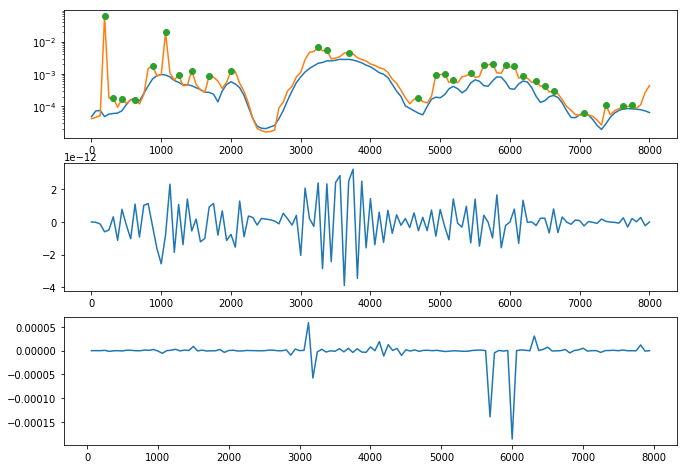

In [132]:
import scipy.signal

pks = scipy.signal.find_peaks(flux_pk_s)

# ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/(np.real(FBz))
# ran = dither #*(np.random.rand(np.shape(FEx)[0], np.shape(FEx)[1]) - 0.5)
# ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/(np.imag(FBz))

freq_pks = ff[pks[0]]
flux_pks = flux_pk_s[pks[0]]*1e9

# print(freq_pks)

fig, ax = plt.subplots(3,1)
ax[0].semilogy(ff, flux_pk*1e9, label = 'Peak')
ax[0].semilogy(ff, flux_pk_s*1e9, label = 'synth')
ax[0].semilogy(freq_pks, flux_pks,'o')

denom = np.abs(FBz[pks[0], tmax_inds[pks[0]]])
denom_pk = [np.imag(FBz[x, tmax_inds[x]]) for x in range(len(ff))]
numer = (np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))
numer_pk = [numer[x, tmax_inds[x]] for x in range(len(ff))]
ax[1].plot(ff, denom_pk)
ax[2].plot(ff, np.array(numer_pk)/np.array(denom_pk))

0
filling imag
1e-10


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


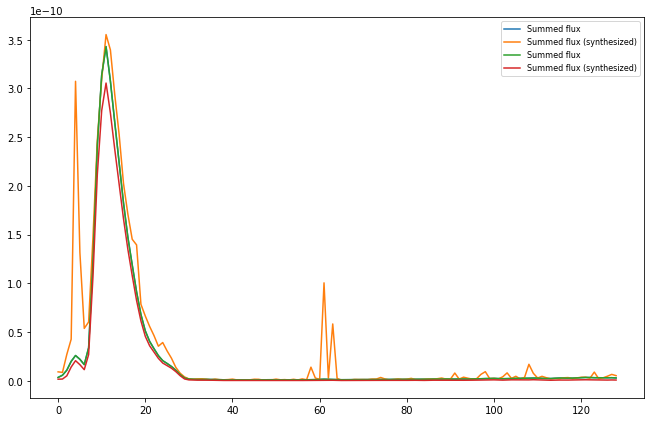

In [91]:
ff,tt, FBx = scipy.signal.spectrogram(bx, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBy = scipy.signal.spectrogram(by, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FBz = scipy.signal.spectrogram(bz, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')

ff,tt, FEx = scipy.signal.spectrogram(ex, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEy = scipy.signal.spectrogram(ey, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')
ff,tt, FEz = scipy.signal.spectrogram(ez, fs=fs, window=window, nperseg=nfft, noverlap=nfft*overlap,mode='complex')


fig, ax = plt.subplots(1,1)
for dither in [0, 1e-10]:
    print(dither)
    # Recreate Ez, because it's noisy and it sucks
    ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/(np.real(FBz) + dither)
    ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/(np.imag(FBz) + dither)


    if np.sum(np.isnan(ReEz))>0:
        print('filling real')
        fill_nans(tt,ff,ReEz)
    if np.sum(np.isnan(ImEz))>0:
        print('filling imag')
        fill_nans(tt,ff,ImEz)

    newEz = ReEz + 1j*ImEz

    # Get poynting flux
    flux = np.zeros([len(ff), len(tt)])

    FB = np.array([FBx, FBy, FBz])
    FE = np.array([FEx, FEy, FEz])
    flux = np.linalg.norm(np.cross(FE, FB, axis=0), axis=0)/mu



    # Get poynting flux
    flux_s = np.zeros([len(ff), len(tt)])

    FB = np.array([FBx, FBy, FBz])
    FE = np.array([FEx, FEy, newEz])
    flux_s = np.linalg.norm(np.cross(FE, FB, axis=0), axis=0)/mu



    ax.plot(np.sum(flux, axis=1), label='Summed flux');
    ax.plot(np.sum(flux_s, axis = 1), label = 'Summed flux (synthesized)');



    ax.legend()

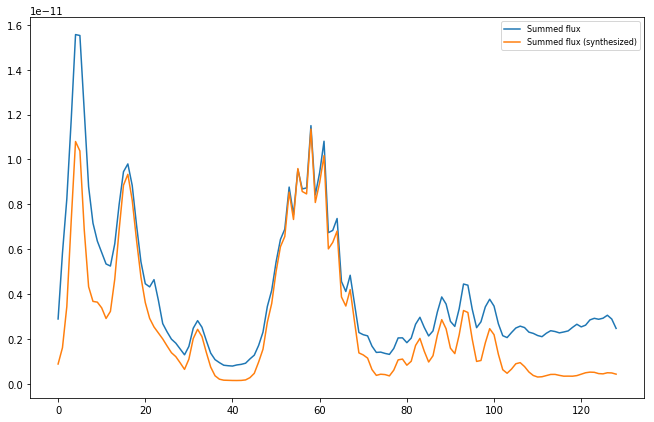

In [55]:
fig, ax = plt.subplots(1,1)
ax.plot(np.sum(flux, axis=1), label='Summed flux');
ax.plot(np.sum(flux_s, axis = 1), label = 'Summed flux (synthesized)');
ax.legend()

(-1.8251531371409942e-05+1.3235788885035852e-06j) (1.996464907959498e-05+4.505759898457726e-06j)


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


(-1.7698003905059956e-18+0j) (3.627438355566684e-17+0j)
(-1.4737742447503538e-17+0j) (1.5783824486812522e-17+0j)


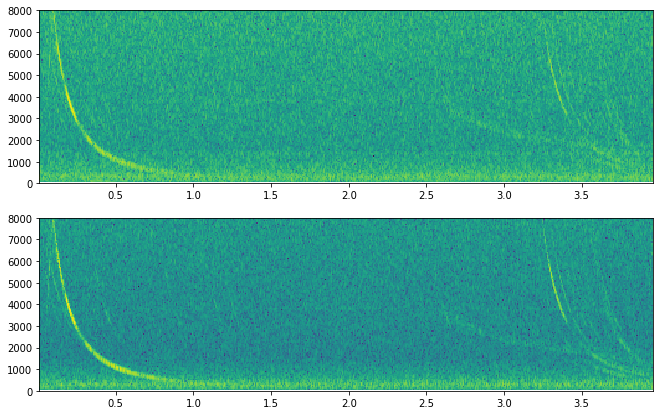

In [45]:
FB = np.array([FBx, FBy, FBz])
FE = np.array([FEx, FEy, FEz])
FE2 = np.array([FEx, FEy, newEz])

print(np.min(FEx), np.max(FEx))

# Recreate Ez, because it's noisy and it sucks
ran = (np.random.rand(np.shape(FEx)[0],np.shape(FEx)[1]) - 0.5)*1e-6
ReEz = -1*(np.real(FEx)*np.real(FBx) + np.real(FEy)*np.real(FBy))/(np.real(FBz) + ran)
ran = (np.random.rand(np.shape(FEx)[0],np.shape(FEx)[1]) - 0.5)*1e-6
ImEz = -1*(np.imag(FEx)*np.imag(FBx) + np.imag(FEy)*np.imag(FBy))/(np.imag(FBz) + ran)


if np.sum(np.isnan(ReEz))>0:
    print('filling real')
    fill_nans(tt,ff,ReEz)
if np.sum(np.isnan(ImEz))>0:
    print('filling imag')
    fill_nans(tt,ff,ImEz)

newEz = ReEz + 1j*ImEz




dd = np.zeros([len(ff), len(tt)], 'complex')
dd2= np.zeros([len(ff), len(tt)], 'complex')

for ti in range(len(tt)):
    for fi in range(len(ff)):  
        dd[fi,ti] = (np.dot(np.imag(FE[:,fi,ti]),  np.imag(FB[:,fi,ti])))
        dd2[fi,ti]= (np.dot(np.imag(FE2[:,fi,ti]), np.imag(FB[:,fi,ti])))

fig, ax = plt.subplots(2,1)
ax[0].pcolormesh(tt,ff,np.log10(np.abs(dd)))
ax[1].pcolormesh(tt,ff,np.log10(np.abs(dd2)))
print(np.min(dd), np.max(dd))
print(np.min(dd2), np.max(dd2))


In [97]:
# Q = np.outer(z,np.conj(z))
Q = []
for row in np.arange(1,7):
    r = []
    for col in np.arange(1,7):
        r.append('%s%s'%(row,col))
    Q.append(r)
    
Q = np.array(Q)
print(Q)
A = []
B = []
for l in range(6):

#     A_tmp = np.zeros([3,3],'complex')
#     B_tmp = np.zeros([3],'complex')
#     A_tmp = np.empty([3,3],'str')
#     B_tmp = np.empty([3],'str')
    A_tmp = [['0','0','0'],['0','0','0'],['0','0','0']]
    B_tmp = ['0','0','0']


    # Valid entries in Levi-Civita symbol
                # Valid entries in Levi-Civita symbol (minus 1, because python is zero-indexed)
    for e,i,j,k in ([1,0,1,2],[1,1,2,0],[1,2,0,1],[-1,0,2,1],[-1,1,0,2],[-1,2,1,0]):
        if e < 0: s = '-'
        else: s=''
        A_tmp[i][j]='%s\Im(Q_{%s})'%(s,Q[k+3,l])
        B_tmp[i] = '\Im(Q_{%s})'%Q[i,l]
#             A_tmp[i][j] = '-Q%s%s'%(i,j)
#         else:
#             A_tmp[i][j] = 'Q%s%s'%(i,j)
# #             print('Q%s'%Q[k+3,1])
# #         A_tmp[i,j] = Q[k+3,l]
# #         B_tmp[i]= Q[i,l]
    A.extend(A_tmp)
    B.extend(B_tmp)
# print(np.array(A))
# print(np.array(B))
st = ''
for r in A:
    for el in r:
        st += el
        st += '  &  '
    st += ' \\\ \n'
print('\\begin{bmatrix} \n')
print(st)
print('\end{bmatrix} \n')
print('=')



st = ''
for r in B:
    st += r
    st += ' \\\ \n'
print('\\begin{bmatrix} \n')
print(st)
print('\end{bmatrix} \n')


    # A2 = np.concatenate([np.real(A),np.imag(A)],axis=0)

[['11' '12' '13' '14' '15' '16']
 ['21' '22' '23' '24' '25' '26']
 ['31' '32' '33' '34' '35' '36']
 ['41' '42' '43' '44' '45' '46']
 ['51' '52' '53' '54' '55' '56']
 ['61' '62' '63' '64' '65' '66']]
\begin{bmatrix} 

0  &  \Im(Q_{61})  &  -\Im(Q_{51})  &   \\ 
-\Im(Q_{61})  &  0  &  \Im(Q_{41})  &   \\ 
\Im(Q_{51})  &  -\Im(Q_{41})  &  0  &   \\ 
0  &  \Im(Q_{62})  &  -\Im(Q_{52})  &   \\ 
-\Im(Q_{62})  &  0  &  \Im(Q_{42})  &   \\ 
\Im(Q_{52})  &  -\Im(Q_{42})  &  0  &   \\ 
0  &  \Im(Q_{63})  &  -\Im(Q_{53})  &   \\ 
-\Im(Q_{63})  &  0  &  \Im(Q_{43})  &   \\ 
\Im(Q_{53})  &  -\Im(Q_{43})  &  0  &   \\ 
0  &  \Im(Q_{64})  &  -\Im(Q_{54})  &   \\ 
-\Im(Q_{64})  &  0  &  \Im(Q_{44})  &   \\ 
\Im(Q_{54})  &  -\Im(Q_{44})  &  0  &   \\ 
0  &  \Im(Q_{65})  &  -\Im(Q_{55})  &   \\ 
-\Im(Q_{65})  &  0  &  \Im(Q_{45})  &   \\ 
\Im(Q_{55})  &  -\Im(Q_{45})  &  0  &   \\ 
0  &  \Im(Q_{66})  &  -\Im(Q_{56})  &   \\ 
-\Im(Q_{66})  &  0  &  \Im(Q_{46})  &   \\ 
\Im(Q_{56})  &  -\Im(Q_{46})  &  0 

In [61]:
Q = []
z = ['cB1','cB2','cB3','E1','E2','E3']
zc = [x+'*' for x in z]
print(z, zc)
for row in np.arange(0,6):
    r = []
    for col in np.arange(0,6):
        r.append('%s%s'%(z[row],zc[col]))
    Q.append(r)
print(np.array(Q))

['cB1', 'cB2', 'cB3', 'E1', 'E2', 'E3'] ['cB1*', 'cB2*', 'cB3*', 'E1*', 'E2*', 'E3*']
[['cB1cB1*' 'cB1cB2*' 'cB1cB3*' 'cB1E1*' 'cB1E2*' 'cB1E3*']
 ['cB2cB1*' 'cB2cB2*' 'cB2cB3*' 'cB2E1*' 'cB2E2*' 'cB2E3*']
 ['cB3cB1*' 'cB3cB2*' 'cB3cB3*' 'cB3E1*' 'cB3E2*' 'cB3E3*']
 ['E1cB1*' 'E1cB2*' 'E1cB3*' 'E1E1*' 'E1E2*' 'E1E3*']
 ['E2cB1*' 'E2cB2*' 'E2cB3*' 'E2E1*' 'E2E2*' 'E2E3*']
 ['E3cB1*' 'E3cB2*' 'E3cB3*' 'E3E1*' 'E3E2*' 'E3E3*']]
